<a href="https://colab.research.google.com/github/taniahdez75/st/blob/main/Fairness1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fairness analysis of adult income dataset.
Dataset: https://archive.ics.uci.edu/ml/datasets/adult

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 10.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif

import shap

In [ ]:
names = ['age','workclass','fnlwgt','education','education-num',
        'marital-status','occupation','relationship','race','sex',
        'capital-gain','capital-loss','hours-per-week','native-country',
        'y']

#Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/fenago/datasets/main/adult-all.csv',names=names,na_values='?')
df = df.dropna()

print(len(df))
df.head()

45222


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
#Snap shot of dataset
df[['age','education-num','marital-status','occupation',
    'hours-per-week','native-country',
    'race','sex','y']].head(10)

,age,education-num,marital-status,occupation,hours-per-week,native-country,race,sex,y
0,39,13,Never-married,Adm-clerical,40,United-States,White,Male,<=50K
1,50,13,Married-civ-spouse,Exec-managerial,13,United-States,White,Male,<=50K
2,38,9,Divorced,Handlers-cleaners,40,United-States,White,Male,<=50K
3,53,7,Married-civ-spouse,Handlers-cleaners,40,United-States,Black,Male,<=50K
4,28,13,Married-civ-spouse,Prof-specialty,40,Cuba,Black,Female,<=50K
5,37,14,Married-civ-spouse,Exec-managerial,40,United-States,White,Female,<=50K
6,49,5,Married-spouse-absent,Other-service,16,Jamaica,Black,Female,<=50K
7,52,9,Married-civ-spouse,Exec-managerial,45,United-States,White,Male,>50K
8,31,14,Never-married,Prof-specialty,50,United-States,White,Female,>50K
9,42,13,Married-civ-spouse,Exec-managerial,40,United-States,White,Male,>50K


Text(0.5, 1.0, 'Race')

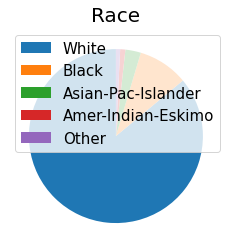

In [ ]:
#Get population count by race
counts = df['race'].value_counts()
labels = counts.index

#Plot pie chart
plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Race",size=20)

Text(0.5, 1.0, 'Gender')

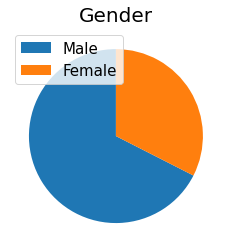

In [ ]:
#Get population count by race
counts = df['sex'].value_counts()
labels = counts.index

#Plot pie chart
plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Gender",size=20)

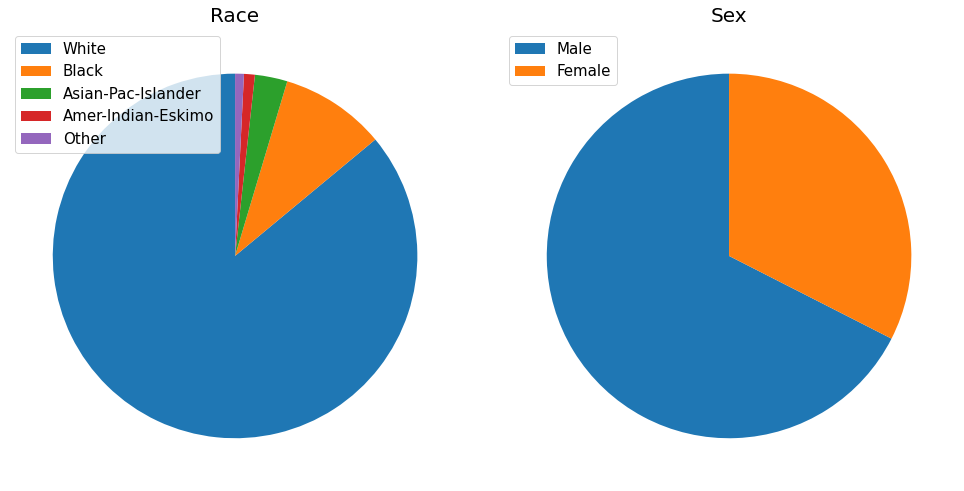

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(121)

#Plot breakdown by race
counts = df['race'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Race",size=20)

plt.subplot(122)

#Plot breakdown by sex
counts = df['sex'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Sex",size=20)


plt.tight_layout(pad=2)
# plt.savefig(path.format('unbalnced_datsets.png'),format='png',dpi=150)

In [ ]:

df_fair = df[['race','sex']]

#Define protected features 
df_fair['priv_race'] = [1 if r=='White' else 0 for r in df_fair['race']]
df_fair['priv_sex'] = [1 if s=='Male' else 0 for s in df_fair['sex']]

#Define target variable 
df_fair['y'] =  [1 if y == '>50K'else 0 for y in df['y']]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Prevalence
#Calculate prevelance
prev = df_fair['y'].mean()
prev_race = df_fair.groupby('priv_race')['y'].mean()
prev_sex = df_fair.groupby('priv_sex')['y'].mean()
prev_comb = df_fair.groupby(['priv_race','priv_sex'])['y'].mean()
print("prev overall " + str(prev))
print("prev by race: " + str(prev_race))
print("prev by gender: " + str(prev_sex))
print("prev combo: " + str(prev_comb))

prev overall 0.2478439697492371
prev by race: priv_race
0    0.158411
1    0.262371
Name: y, dtype: float64
prev by gender: priv_sex
0    0.113576
1    0.312477
Name: y, dtype: float64
prev combo: priv_race  priv_sex
0          0           0.076102
           1           0.224408
1          0           0.122444
           1           0.323908
Name: y, dtype: float64


In [ ]:
# Proxy Variables
# mutual information and feature importance
#Target variable 
y = [1 if y == '>50K' else 0 for y in df['y']]

#Model features
X = df[['age','education-num','hours-per-week']]
X['marital-status'] = [1 if x=='Married-civ-spouse' else 0 for x in df['marital-status']] 
X['native-country'] = [1 if x=='United-States' else 0 for x in df['native-country']] 

occ_groups = {
    'Priv-house-serv':0,'Other-service':0,'Handlers-cleaners':0,
    'Farming-fishing':1,'Machine-op-inspct':1,'Adm-clerical':1,
    'Transport-moving':2,'Craft-repair':2,'Sales':2,
    'Armed-Forces':3,'Tech-support':3,'Protective-serv':3,
    'Prof-specialty':4,'Exec-managerial':4}

X['occupation'] = [occ_groups[x] for x in df['occupation']]

X.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,age,education-num,hours-per-week,marital-status,native-country,occupation
0,39,13,40,0,1,1
1,50,13,13,1,1,4
2,38,9,40,0,1,0
3,53,7,40,1,1,0
4,28,13,40,1,0,4


([<matplotlib.axis.XTick at 0x7f5d434b7c40>,
 [Text(0, 0, 'age'),
  Text(1, 0, 'education-num'),
  Text(2, 0, 'hours-per-week'),
  Text(3, 0, 'marital-status'),
  Text(4, 0, 'native-country'),
  Text(5, 0, 'occupation')])

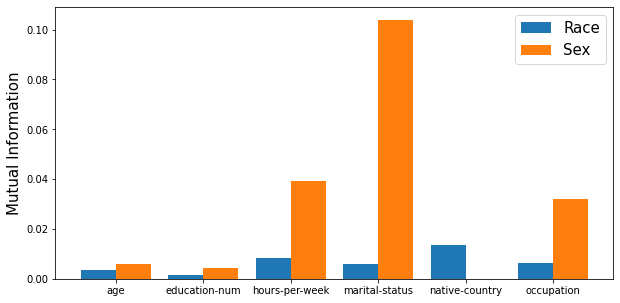

In [ ]:
#Mutual information 

#Calcualte mutual information
mut_race = mutual_info_classif(X,df_fair['priv_race'],discrete_features=[1,3,4,5])
mut_sex = mutual_info_classif(X,df_fair['priv_sex'],discrete_features=[1,3,4,5])


#Plot mutual information 
plt.figure(figsize=(10, 5))

labels = ['age', 'education-num', 'hours-per-week', 'marital-status',
       'native-country', 'occupation']
x = np.arange(len(labels)) 
width = 0.4
plt.bar(x-width/2,height= mut_race,width=width,label='Race')
plt.bar(x+width/2,height= mut_sex,width=width,label='Sex')
plt.legend(fontsize=15)

plt.ylabel('Mutual Information',size=15)
plt.xticks(ticks=x,labels=labels)

In [ ]:
#Feature importance race

# Get balanced sample 
y_race_0 = df_fair[df_fair['priv_race'] == 0]['priv_race']
y_race_1 = df_fair[df_fair['priv_race'] == 1]['priv_race']
y_race_1 = y_race_1.sample(len(y_race_0))
y_race = y_race_0.append(y_race_1)

X_race = X.loc[y_race.index]

#Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_race, y_race)
y_pred = model.predict(X_race)

#Calculate accuracy 
acc_race = accuracy_score(y_race, y_pred)

#Get feature importance 
fi_race = model.get_booster().get_score(importance_type='weight')


#Output results 
print(acc_race)
print(confusion_matrix(y_race, y_pred))
print(classification_report(y_race, y_pred))

0.6711504984965976
[[4188 2131]
 [2025 4294]]
              precision    recall  f1-score   support

           0       0.67      0.66      0.67      6319
           1       0.67      0.68      0.67      6319

    accuracy                           0.67     12638
   macro avg       0.67      0.67      0.67     12638
weighted avg       0.67      0.67      0.67     12638



In [ ]:
#Feature importance sex

# Get balanced sample 
y_sex_0 = df_fair[df_fair['priv_sex'] == 0]['priv_sex']
y_sex_1 = df_fair[df_fair['priv_sex'] == 1]['priv_sex']
y_sex_1 = y_sex_1.sample(len(y_sex_0))
y_sex = y_sex_0.append(y_sex_1)

X_sex = X.loc[y_sex.index]

#Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_sex, y_sex)

y_pred = model.predict(X_sex)

#Calculate accuracy 
acc_sex = accuracy_score(y_sex, y_pred)

#Get feature importance 
fi_sex = model.get_booster().get_score(importance_type='weight')

#Output results 
print(acc_sex)
print(confusion_matrix(y_sex, y_pred))
print(classification_report(y_sex, y_pred))

0.7656005444028581
[[12057  2638]
 [ 4251 10444]]
              precision    recall  f1-score   support

           0       0.74      0.82      0.78     14695
           1       0.80      0.71      0.75     14695

    accuracy                           0.77     29390
   macro avg       0.77      0.77      0.76     29390
weighted avg       0.77      0.77      0.76     29390



([<matplotlib.axis.XTick at 0x7f5d431ba160>,
 [Text(0, 0, 'age'),
  Text(1, 0, 'education-num'),
  Text(2, 0, 'hours-per-week'),
  Text(3, 0, 'marital-status'),
  Text(4, 0, 'native-country'),
  Text(5, 0, 'occupation')])

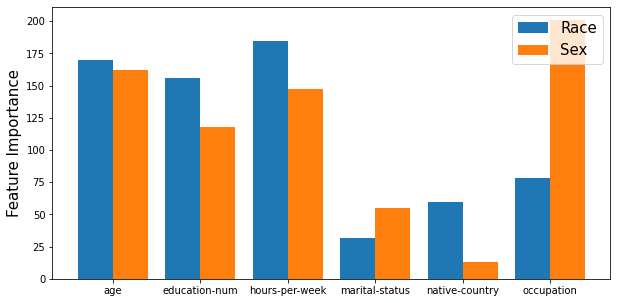

In [ ]:
#Plot feature importance
plt.figure(figsize=(10, 5))

labels = ['age', 'education-num', 'hours-per-week', 'marital-status',
       'native-country', 'occupation']

fi_race = [fi_race[l] for l in labels]
fi_sex = [fi_sex[l] for l in labels]


x = np.arange(len(labels)) 
width = 0.4
plt.bar(x-width/2,height= fi_race,width=width,label='Race')
plt.bar(x+width/2,height= fi_sex,width=width,label='Sex')
plt.legend(fontsize=15)

plt.ylabel('Feature Importance',size=15)
plt.xticks(ticks=x,labels=labels)

In [ ]:
# Model - Measuring Fairness
#Train model 
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X, y)

#Get predictions
y_pred = model.predict(X)
df_fair['y_pred'] = y_pred

print(confusion_matrix(y, y_pred))
print(accuracy_score(y, y_pred))
print(classification_report(y, y_pred))

[[31323  2691]
 [ 4863  6345]]
0.8329574101101234
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     34014
           1       0.70      0.57      0.63     11208

    accuracy                           0.83     45222
   macro avg       0.78      0.74      0.76     45222
weighted avg       0.83      0.83      0.83     45222




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
def fairness_metrics(df):
    """Calculate fairness for subgroup of population"""
    
    #Confusion Matrix
    cm=confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    N = TP+FP+FN+TN
    
    # Overall accuracy
    ACC = (TP+TN)/N
    
    # True positive rate
    TPR = TP/(TP+FN)
    
    # False positive rate
    FPR = FP/(FP+TN)
    
    # False negative rate
    FNR = FN/(TP+FN)
    
    # Percentage predicted as positive
    PPP = (TP + FP)/N
    
    return np.array([ACC, TPR, FPR, FNR, PPP])  

In [ ]:
#Calculate fairness metrics for race
fm_race_1 = fairness_metrics(df_fair[df_fair.priv_race==1])
fm_race_0 = fairness_metrics(df_fair[df_fair.priv_race==0])

#Get ratio of fairness metrics
fm_race = fm_race_0/fm_race_1

print(fm_race_1)
print(fm_race_0)
print(fm_race)

[0.82502635 0.57294014 0.08530806 0.42705986 0.21324834]
[0.88178509 0.4965035  0.04569387 0.5034965  0.11710714]
[1.06879628 0.86658878 0.5356337  1.17898344 0.54915851]


In [ ]:
#Calculate fairness metrics for sex
fm_sex_1 = fairness_metrics(df_fair[df_fair.priv_sex==1])
fm_sex_0 = fairness_metrics(df_fair[df_fair.priv_sex==0])


#Get ratio of fairness metrics
fm_sex = fm_sex_0/fm_sex_1

print(fm_sex_1)
print(fm_sex_0)
print(fm_sex)

[0.79460805 0.59922424 0.11659043 0.40077576 0.26740263]
[0.91262334 0.37687238 0.01873177 0.62312762 0.05940796]
[1.14852013 0.6289338  0.16066299 1.55480366 0.22216671]


In [ ]:
df_fair['marital-status'] = X['marital-status']

#Calculate figures
count_ms = df_fair.groupby(['priv_sex','marital-status'])['priv_sex'].count()
prev_ms = df_fair.groupby(['marital-status'])['y'].mean()
prev_sex = df_fair.groupby(['priv_sex'])['y'].mean()

print(count_ms)
print(prev_ms)
print(prev_sex)

priv_sex  marital-status
0         0                 12482
          1                  2213
1         0                 11685
          1                 18842
Name: priv_sex, dtype: int64
marital-status
0    0.068027
1    0.454239
Name: y, dtype: float64
priv_sex
0    0.113576
1    0.312477
Name: y, dtype: float64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
